# Evaluation workflow

Using the example datasets, we show the performance across a range of use cases and produce the plots used in the accompanying paper.

Please note this has improved (corrected) hyperparameters to the paper which will be updated accordingly when access is available.

In [1]:
# import functions
import time
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from HEADSS import headss_merge
from matplotlib.colors import ListedColormap

In [2]:
# Get less intense colormaps

def reduce_intesity(cmap = 'prism', intensity = 0.75, plot = False): 
    '''Reduce the intensity of bright colormaps'''
    cmap = plt.cm.get_cmap(cmap)
    # Get the colormap colors, multiply them with the factor "a", and create new colormap
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,0:3] *= intensity
    my_cmap = ListedColormap(my_cmap)
    if plot:
        np.random.seed(1)
        data =  np.sort(np.random.rand(8,12))
        plt.figure()
        plt.subplot(121)
        c = plt.pcolor(data, edgecolors='k', linewidths=4, cmap=cmap, vmin=0.0, vmax=1.0)
        plt.colorbar(c)
        plt.subplot(122)
        c = plt.pcolor(data, edgecolors='k', linewidths=4, cmap=my_cmap, vmin=0.0, vmax=1.0)
        plt.colorbar(c)
        plt.show()
    return my_cmap

# Create less intense colormaps.
reduced_prism = reduce_intesity(cmap = 'prism', intensity = 0.85, plot = False)
reduced_tab20 = reduce_intesity(cmap = 'tab20', intensity = 0.85, plot = False)

In [3]:
'''Functions used to ensure suitable plotting parameters.'''


def get_ax(ax, figsize = None):
    '''returns an axis if ax = None in plotting functions'''
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = figsize)
    return ax

def getPlottingWormsParams():
    '''Parameters for improved "worms" visualisation'''
    xlim = ylim = (1800,5500)
    alpha = 0.05
    s = 1
    return xlim, ylim, alpha, s

def getPlottingBirch1Params():
    '''Parameters for improved "birch1" visualisation'''
    xlim = ylim = (0,1e6)
    alpha = 0.25
    s = 1
    return xlim, ylim, alpha, s

def getPlottingParams(dataset, size = 15):
    '''Parameters for all example datasets visualisations'''
    if dataset == 'worms':
        xlim, ylim, alpha, size = getPlottingWormsParams()
    elif dataset == 'birch1':
        xlim, ylim, alpha, size = getPlottingBirch1Params()
    else: xlim = ylim = None; alpha = 1; size = size
    return xlim, ylim, alpha, size

def plotData(data, dataset = None, cols = ['x', 'y'], color = 'k', ax = None, 
             axis = True, fontsize = 14, cmap = 'tab20c', size = 15):
    """Plots example datasets
    INPUT
           data              - data to plot [Pandas DataFrame]
        dataset = None       - dataset name for plotting parameters 
                                   (see "getPlottingParams")
           cols = ['x', 'y'] - columns to be plotted [list]
          color = 'k'        - marker color [str]
             ax = None       - Subplot axis if multiple plots are desired
           axis = True       - Show axis [bool]
          color = 'k'        - marker color [str or data[column] for cmap].
           size = 15         - markersize [int]
        """
    ax = get_ax(ax = ax)
    xlim, ylim, alpha, size = getPlottingParams(dataset, size = size)
    ax.scatter(data[cols[0]], data[cols[1]], s = size, alpha = alpha, 
               c = color, cmap = cmap)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(dataset, fontsize = fontsize+4)
    if not axis:
        ax.set_xticks([])
        ax.set_yticks([])   

In [4]:
'''Functions used to retrieve the example datasets'''


def open_txt_file(filename):
    '''opens txt files and returns as a list'''
    f = open(filename, "r")
    d = f.read()
    d = d.split('\n')
    return d

def getData(dataset, plot = False, ax = None, axis = True, fontsize = 16, size = 15):
    '''Opens example datasets returning them as a Pandas DataFrame'''
    
    filename = 'test_data/'
    known_types = ['Aggregation','a3','flame','pathbased','spiral','D31',
                   'birch1','jain','t4.8k', 'worms']
    # Open data
    if dataset == 'worms':
        data = open_txt_file(f'{filename}worms/worms_2d.txt')
    elif dataset != 'worms' and dataset in known_types:
        data = open_txt_file(f'{filename}{dataset}.txt')
    else:
        raise NameError(f'Known synthetic datatypes include {known_types}')
    data = [i.split() for i in data] # Split data types
    data = pd.DataFrame(data[:-1]).astype(float) # move into Pandas
    # Rename features as x,y ignoring additional columns
    data = data.rename(columns = {0:'x', 1:'y'})
    if plot: # Simple plotting feature for visualisation
        plotData(data = data, dataset = dataset, ax = ax, axis = axis, 
                 fontsize = fontsize, size = size)
    return data

Dataset = Aggregation | 788 datapoints
Dataset = a3 | 7500 datapoints
Dataset = flame | 240 datapoints
Dataset = pathbased | 300 datapoints
Dataset = spiral | 312 datapoints
Dataset = D31 | 3100 datapoints
Dataset = birch1 | 100000 datapoints
Dataset = jain | 373 datapoints
Dataset = t4.8k | 8000 datapoints
Dataset = worms | 105600 datapoints


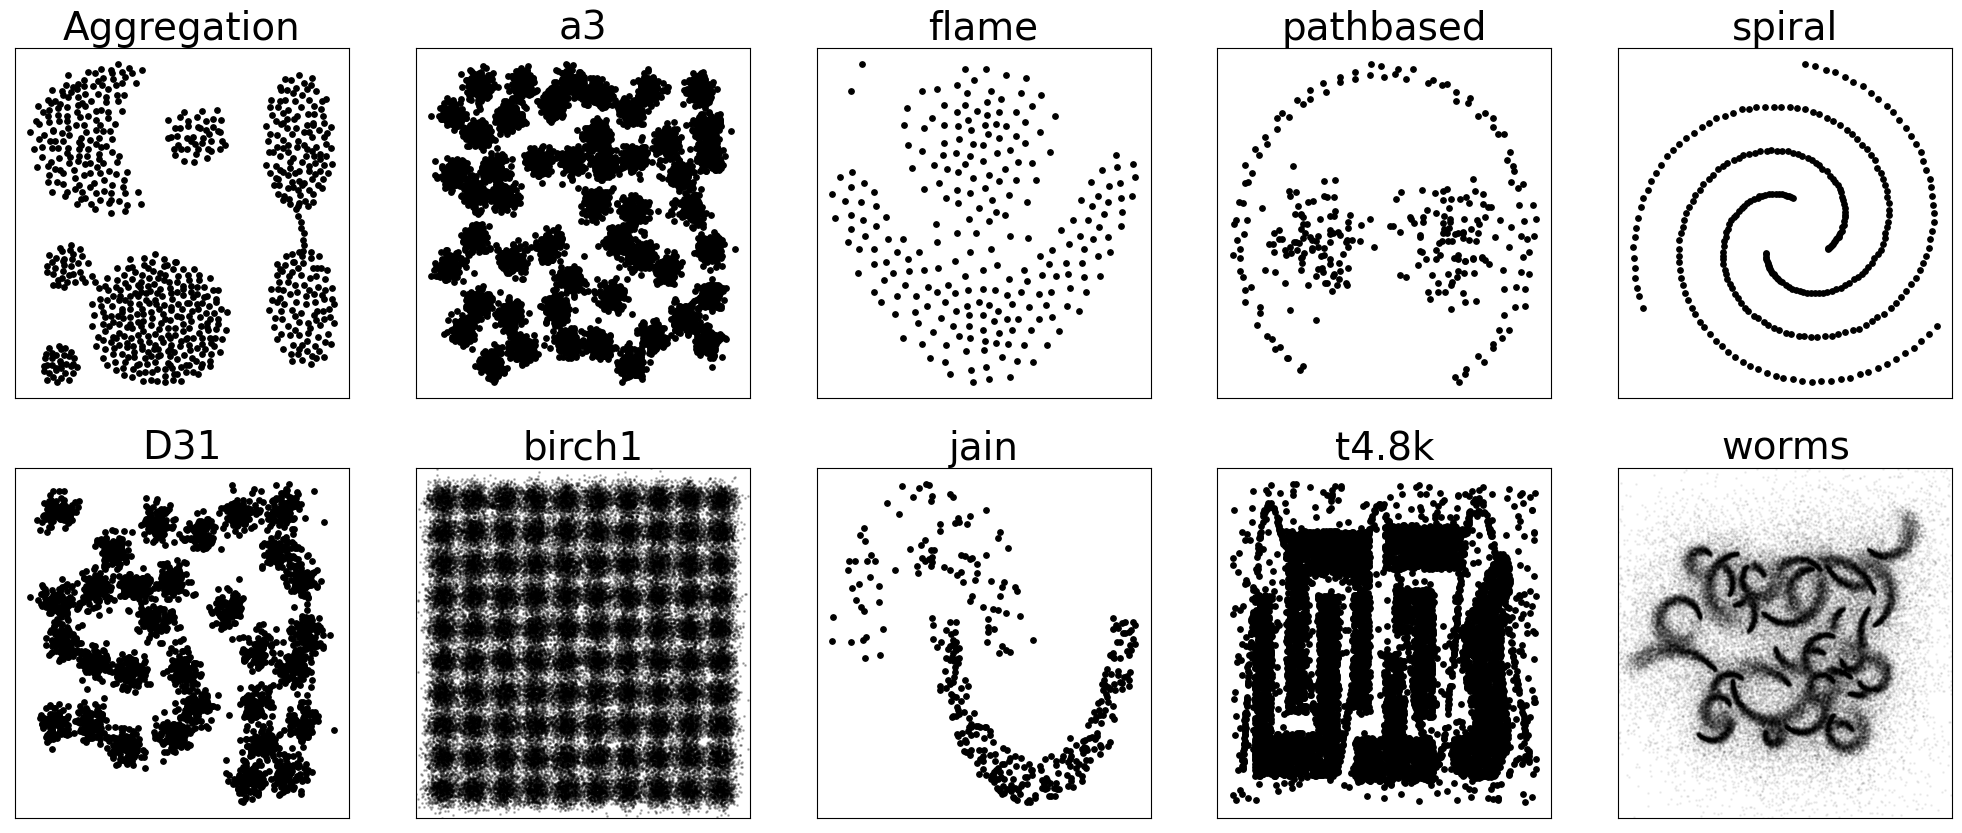

In [5]:
'''Show example datasets'''
def show_available_data(known_types, fontsize = 16):
    '''plot all example datasets'''
    
    fig, axes = plt.subplots(2,5, figsize = (25, 10))
    axs = axes.ravel()
    for i, dataset in enumerate(known_types):
        data = getData(dataset = dataset, plot = True,
                       ax = axs[i], axis = False, fontsize = fontsize)
        print(f'Dataset = {dataset} | {len(data)} datapoints') # Dataset info

# list of example datasets
known_types = ['Aggregation','a3','flame','pathbased','spiral','D31',
                   'birch1','jain','t4.8k', 'worms']
show_available_data(known_types, fontsize = 24,)
plt.show()

In [6]:
'''Get DataFrame of clustering hyperparameters for all example datasets. 
This is NOT required unless evaluating multiple datasets such as this example.'''

def getHyperparams(known_types = None, min_samples = None, min_cluster_size = None,
                   cluster_method = None, allow_single_cluster = None):
    '''Get hyperparameters for HDBSCAN clusters of the example datasets
    RETURNS 
        DataFrame of hyperparameters'''
    
    if type(known_types) == type(None):
        known_types = ['Aggregation','a3','flame','pathbased','spiral','D31',
                       'birch1','jain','t4.8k', 'worms']
    if type(min_samples) == type(None):
        min_samples = [None, None, None, None, None, None, None, None, None, None]
    if type(min_cluster_size) == type(None):    
        min_cluster_size = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
    if type(allow_single_cluster) == type(None):
        allow_single_cluster = [False, False, False, False, False, 
                                False, False, False, False, False]
    if type(cluster_method) == type(None):
        cluster_method = ['eom', 'eom', 'eom', 'eom', 'eom',
                          'eom', 'eom', 'eom', 'eom', 'eom']
    hyperparams = pd.DataFrame(known_types, columns = ['dataset'])
    hyperparams['min_samples'] = min_samples
    hyperparams['allow_single_cluster'] = allow_single_cluster
    hyperparams['cluster_method'] = cluster_method
    hyperparams['min_cluster_size'] = min_cluster_size
    hyperparams = hyperparams.set_index('dataset')
    return hyperparams

In [7]:
'''Get DataFrame of merging hyperparameters for all example datasets. 
This is NOT required unless evaluating multiple datasets such as this example.'''

def getMergeParameters(known_types = None, merge = None, minimum_members = None, 
                       total_threshold = None, overlap_threshold = None,):
    '''Return a table of merging parameters of known datasets for N = 2 HEADSS.'''
    
    if type(known_types) == type(None):
        known_types = ['Aggregation','a3','flame','pathbased','spiral','D31',
                       'birch1','jain','t4.8k', 'worms']
    if type(minimum_members) == type(None):
        min_members = [3, None, 1, 1, 1, 
                       None, None, 1, 10, 1]
    if type(overlap_threshold) == type(None):    
        overlap_threshold = [0.9, None, 0.5, 0.5, 0.01, 
                             None, None, 0.7, 0.5, 0.5]
    if type(total_threshold) == type(None):
        total_threshold = [0.1, None, 0.1, 0.1, 0.01, 
                           None, None, 0.1, 0.1, 0.1]
    if type(merge) == type(None):
        merge = [True, False, True, True, True,
                          False, False, True, True, True]
    hyperparams = pd.DataFrame(known_types, columns = ['dataset'])
    hyperparams['merge'] = merge
    hyperparams['total_threshold'] = total_threshold
    hyperparams['overlap_threshold'] = overlap_threshold
    hyperparams['minimum_members'] = min_members
    hyperparams = hyperparams.set_index('dataset')
    return hyperparams

In [8]:
'''Define an evaluation tool using HEADSS for all test datasets and 
hyperparameters input as a DataFrame.'''

def test_data_subplots(known_types, hyperparams, N = 2, columns = ['x', 'y'],  
                     merge_hyperparams = None, fontsize = 16, 
                     cmap = 'tab20c', axis = None, size = 15, merge_clusters = False):
    '''plots all available data, using HEADSS with a NxN split'''
    fig, axes = plt.subplots(2,5, figsize = (25, 10))
    axs = axes.ravel()        
    for i, dataset in enumerate(known_types[:]):
        # Allow different maps for each dataset
        if type(cmap) == list:
            cmp = cmap[i]
        else:
            cmp = cmap
        if not merge_clusters:
            merge = False
            overlap_threshold = total_threshold = minimum_members = 1
        else:
            merge = merge_hyperparams.loc[dataset, 'merge']
            overlap_threshold = merge_hyperparams.loc[dataset, 'overlap_threshold']
            total_threshold   = merge_hyperparams.loc[dataset, 'total_threshold']
            minimum_members   = merge_hyperparams.loc[dataset, 'minimum_members']
        data = getData(dataset=dataset, plot = False)
        # Get result of HEADSS split/stitch clustering.
        start = time.time()
        head = headss_merge(df = data, split_columns = columns, N = 2, 
                    merge = merge,
                    min_samples          = int(hyperparams.loc[dataset, 'min_samples']),
                    cluster_method       = hyperparams.loc[dataset, 'cluster_method'],
                    allow_single_cluster = hyperparams.loc[dataset, 'allow_single_cluster'],
                    min_cluster_size     = int(hyperparams.loc[dataset, 'min_cluster_size']),
                    overlap_threshold = overlap_threshold,
                    total_threshold   = total_threshold,
                    minimum_members   = minimum_members)
        df = head.members_df

        print(f'{dataset} takes {time.time() - start:.2f} seconds')
        plotData(data = df, dataset = dataset, color=df.group, size = size,
                 cmap = cmp, ax = axs[i], axis = axis, fontsize = fontsize)
    plt.show()

Aggregation takes 0.35 seconds
a3 takes 0.68 seconds
flame takes 0.16 seconds
pathbased takes 0.16 seconds
spiral takes 0.19 seconds
D31 takes 0.43 seconds
birch1 takes 6.15 seconds
jain takes 0.19 seconds
t4.8k takes 0.55 seconds
worms takes 21.67 seconds


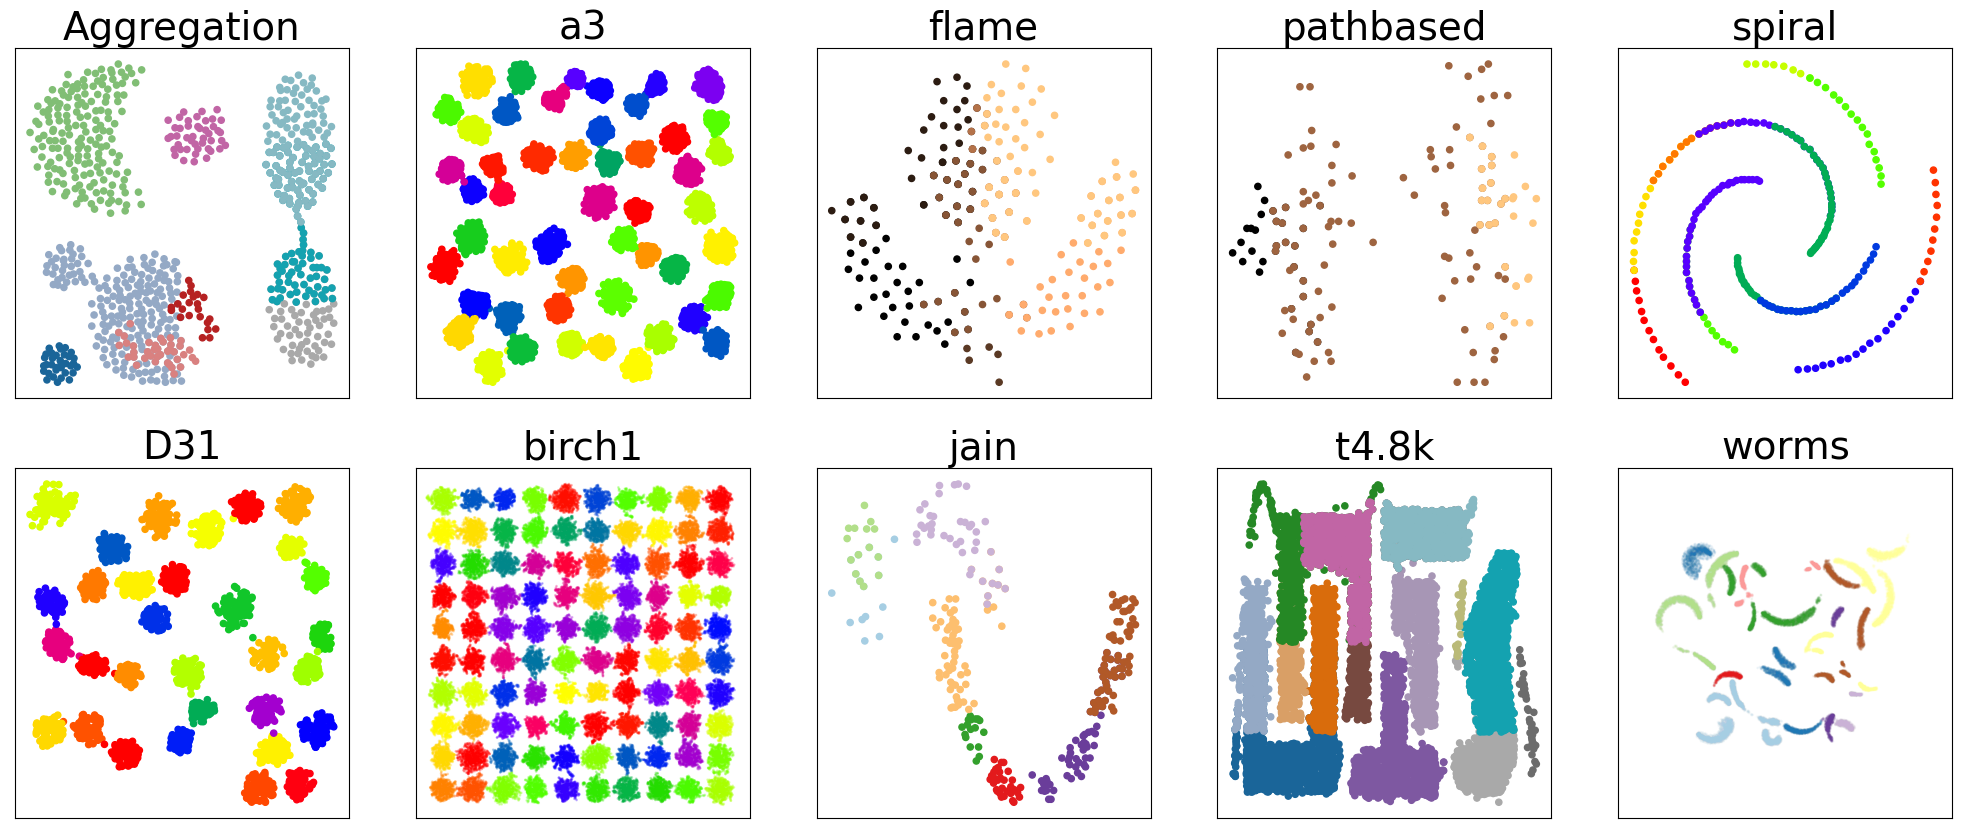

In [9]:
'''Set up clustering parameters and merging for all 10 datasets into DataFrames. 
DataFrames are not needed if using on a single dataset '''

merge_hyperparams = getMergeParameters()
cut_hyperparams = getHyperparams(min_samples = [10, 20, 10, 10, 10,
                                                 20, 10, 10, 10, 200],
                        min_cluster_size = [10, 20, 5, 30, 3, 
                                            20, 200, 5, 30, 100],
                        cluster_method = ['eom', 'leaf', 'eom', 'eom', 'leaf',
                                          'leaf', 'leaf', 'eom', 'eom', 'leaf'],
                        allow_single_cluster = [False, False, True, True, True, 
                                                False, False, False, False, False])

# Define list of color maps for optimal viewing
cmap = [reduced_tab20, 'prism', 'copper', 'copper', 'prism',
    'prism', 'prism', 'Paired', reduced_tab20, 'Paired']

# show clustering results with HEADSS with merging disabled.
test_data_subplots(known_types = known_types, hyperparams = cut_hyperparams, N = 2, 
                   size = 20, cmap = cmap, fontsize = 24, 
                   merge_clusters = False)

Aggregation takes 0.43 seconds
a3 takes 0.67 seconds
flame takes 0.37 seconds
pathbased takes 0.20 seconds
spiral takes 0.64 seconds
D31 takes 0.40 seconds
birch1 takes 5.50 seconds
jain takes 0.47 seconds
t4.8k takes 1.46 seconds
worms takes 19.28 seconds


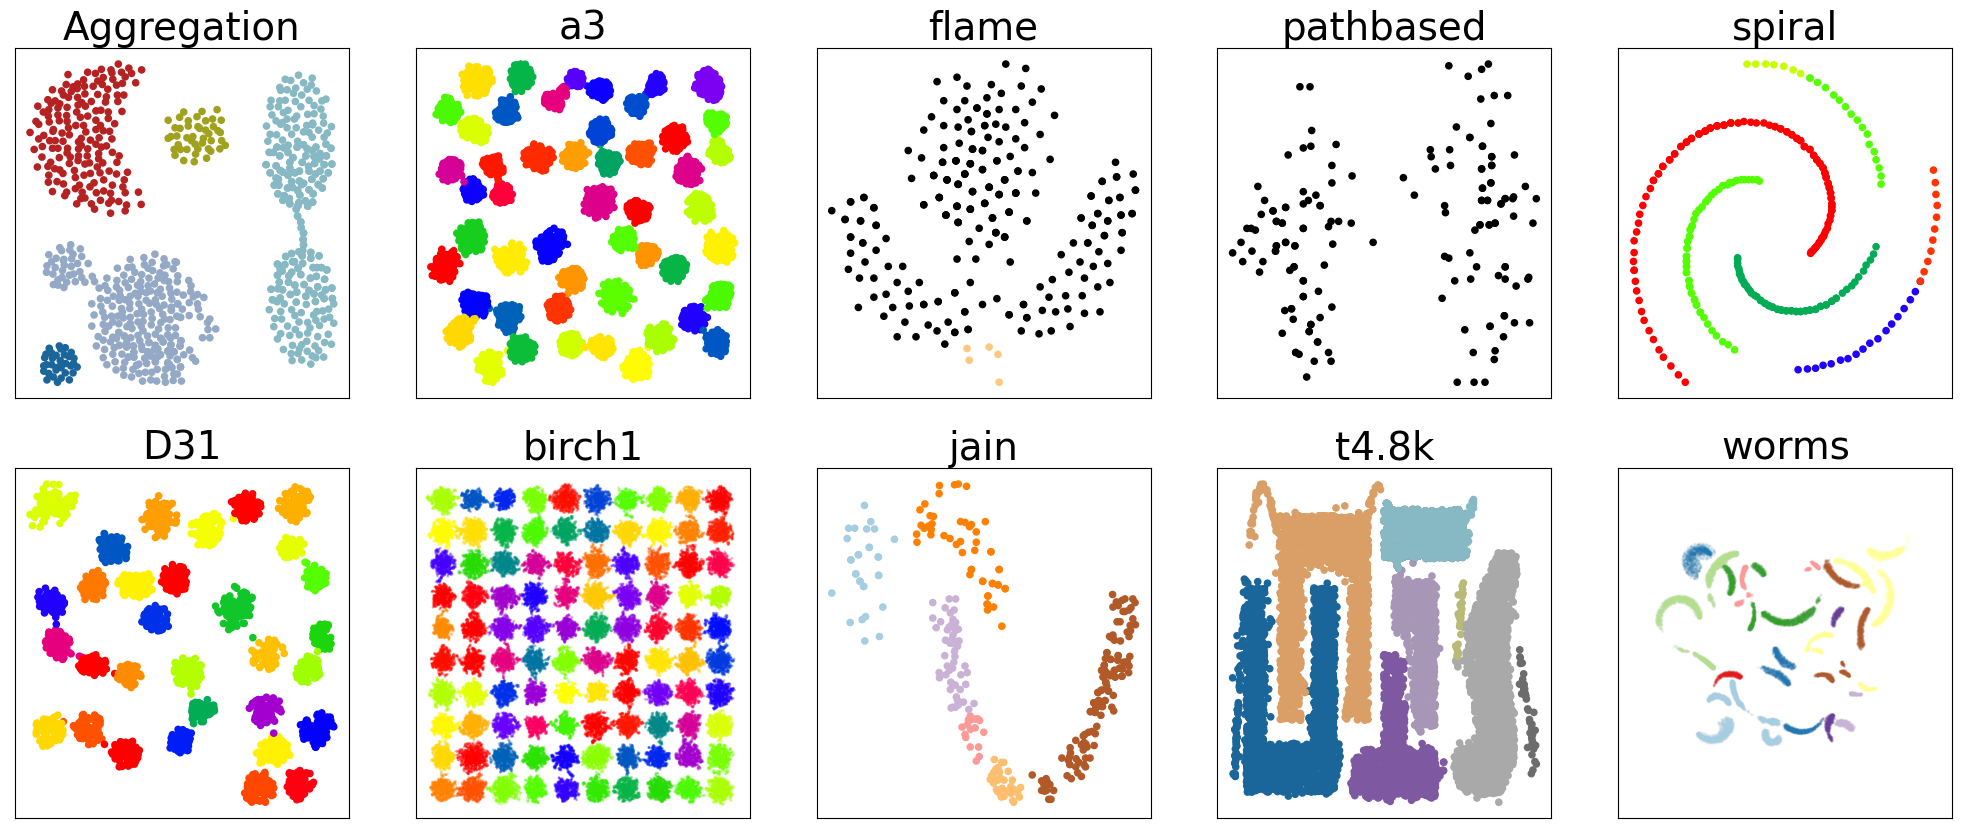

In [10]:
# show clustering results with HEADSS with merging enabled.
test_data_subplots(known_types = known_types, hyperparams = cut_hyperparams, N = 2, 
                   size = 20, cmap = cmap, fontsize = 24, merge_clusters = True,
                   merge_hyperparams = merge_hyperparams)

This clearly deomstrates the ability of HEADSS across a wide range of use cases. Furthermore, we highlight the abilities of merging the clusters to recover more accurate clustering results. If users want to test other datasets please see "quick_start.ipynb" or to further understand the processes involved please see "train.ipynb"